In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import Dataset

In [26]:
def normalize_heatmap(heatmap):
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()
    return heatmap

def generate_heatmap(image_shape, landmarks, sigma=1.0, scale=1.0):
    k, H, W = image_shape
    heatmaps = np.zeros((k, H, W), dtype=np.float32)
    
    for idx, (x, y) in enumerate(landmarks):
        x_scaled = int(np.round(x * scale))
        y_scaled = int(np.round(y * scale))
        
        x_range = np.arange(0, W)
        y_range = np.arange(0, H)
        X, Y = np.meshgrid(x_range, y_range)
        
        heatmap = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-((X - x_scaled) ** 2 + (Y - y_scaled) ** 2) / (2 * sigma ** 2))
        heatmaps[idx] = normalize_heatmap(heatmap)
    
    return heatmaps

In [27]:
def overlay_heatmaps(image, heatmaps, alpha=0.5, colormap=cv2.COLORMAP_HOT):
    overlayed_image = image.astype(np.float32)

    for heatmap in heatmaps:
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap_resized = cv2.normalize(heatmap_resized, None, 0, 1, cv2.NORM_MINMAX)
        heatmap_resized = np.power(heatmap_resized, 0.5)  # Increase contrast
        
        heatmap_normalized = (heatmap_resized * 255).astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_normalized, colormap).astype(np.float32)

        overlayed_image = cv2.addWeighted(overlayed_image, 1.0, heatmap_colored, alpha, 0)

    overlayed_image = np.clip(overlayed_image, 0, 255).astype(np.uint8)

    return overlayed_image

In [28]:
def apply_fifa_augmentation(image, landmarks, patch_size_start, epochs, interval):
    img_aug = image.copy()
    h, w, _ = image.shape
    
    for epoch in range(epochs):
        k = epoch // interval
        patch_size = max(1, patch_size_start - k)
        half_patch = patch_size // 2
        
        for (x, y) in landmarks:
            top_left = (int(x - half_patch), int(y - half_patch))
            bottom_right = (int(x + half_patch), int(y + half_patch))
            
            if (0 <= top_left[0] < w and 0 <= top_left[1] < h and
                0 <= bottom_right[0] < w and 0 <= bottom_right[1] < h):
                cv2.rectangle(img_aug, top_left, bottom_right, (0, 0, 0), -1)
    
    return img_aug

In [29]:
dataset = Dataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/afw')

In [30]:
img, imgMirror, points = dataset.__getitem__(0)

In [66]:
img_fifa_augmented = apply_fifa_augmentation(img, points, patch_size_start=4, epochs=5, interval=1)

In [47]:
heatmaps = generate_heatmap((len(points), img.shape[0], img.shape[1]), points)

In [44]:
img_with_heatmaps = overlay_heatmaps(img, heatmaps, alpha=0.6)

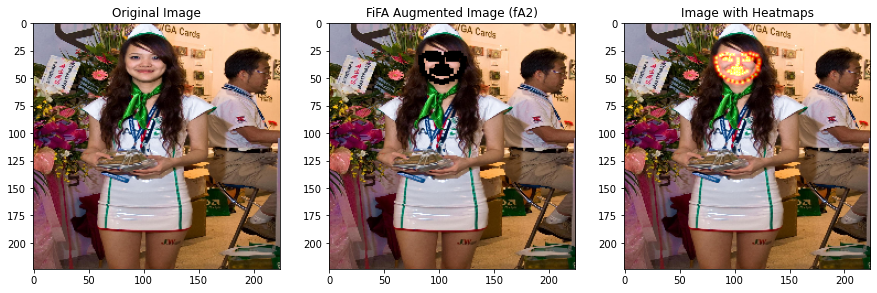

In [67]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_fifa_augmented, cv2.COLOR_BGR2RGB))
plt.title('FiFA Augmented Image (fA2)')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_with_heatmaps, cv2.COLOR_BGR2RGB))
plt.title('Image with Heatmaps')

plt.show()

In [35]:
class LandmarkModel(nn.Module):
    def __init__(self, input_channels=3, num_landmarks=68):
        super(LandmarkModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle variable sizes
        self.fc1 = nn.Linear(128, 1000)
        self.fc2 = nn.Linear(1000, num_landmarks * 2)  # Output landmarks

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)  # Adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 68, 2).float()  # Reshape to [batch_size, 68, 2]

In [39]:
def train_model(model, dataloader, criterion, optimizer, epochs=25):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for inputs, _, landmarks in dataloader:
            inputs = inputs.permute(0, 3, 1, 2).float().to(device)  # Convert images to [B, C, H, W] and move to device
            landmarks = landmarks.float().to(device)  # Ensure landmarks are Float
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, landmarks)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}')
        print(f"Model output dtype: {outputs.dtype}")
        print(f"Landmarks dtype: {landmarks.dtype}")
        print(f"Loss dtype: {loss.dtype}")
    
    return model

In [ ]:
# Initialize DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LandmarkModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
trained_model = train_model(model, dataloader, criterion, optimizer, epochs=25)

In [ ]:
# Save the model
torch.save(trained_model.state_dict(), 'model/landmark_model.pth')

# Load the model (for inference later)
model.load_state_dict(torch.load('model/landmark_model.pth'))
model.eval()